In [53]:
import pandas as pd
def import_data(data_name, base_path="results/_overall/_overall", regression=None):
    df = pd.DataFrame()
    for num_train in [32, 64, 128, 256, 512]:
        new_df = pd.read_csv(f"results/_overall/_overall/{data_name}/{data_name}_num_train-{num_train}.csv")
        new_df["num_train"] = num_train
        df = pd.concat([df, new_df])
    # find if classification or regression
    if regression is None:
        if "yate-gnn_rmse" in df.columns:
            regression = True
        elif "yate-gnn_roc_auc" in df.columns:
            regression = False
        else:
            raise ValueError("Cannot find regression or classification in columns")

    df_melted = pd.melt(df, id_vars=['random_state', 'num_train'])

    # Extract model name and metric
    df_melted['model'] = df_melted['variable'].str.extract(r'(^.*?)_')
    if regression:
        df_melted['metric'] = df_melted['variable'].str.extract(r'_(rmse|r2|run_time)$')
    else:
        df_melted['metric'] = df_melted['variable'].str.extract(r'_(roc_auc|avg_precision|run_time)$')

    # Pivot table
    df_pivot = df_melted.pivot_table(index=['random_state', 'num_train', 'model'], columns='metric', values='value', aggfunc='first').reset_index()

    return df_pivot, regression
    


## Create a fixed palette for models across all plots

In [87]:
datasets = ["company_employees", "museums", "us_accidents_counts", "us_accidents_severity"]
df_all_origin = pd.DataFrame()
for dataset in datasets:
    new_df, regression = import_data(dataset)
    new_df["dataset"] = dataset
    if regression:
        new_df["score"] = new_df["r2"]
    else:
        new_df["score"] = new_df["roc_auc"]
    df_all_origin = pd.concat([df_all_origin, new_df])


In [71]:
# Assuming these are your models
models = df_all_origin['model'].unique()

# Example colors, you can modify this list based on your preferences or number of models
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Create a dictionary mapping model names to colors
model_color_palette = dict(zip(models, colors))

# Learning curves

In [54]:
df_pivot, regression = import_data("museums")

In [57]:
# remove mlp

df_pivot = df_pivot[df_pivot['model'] != 'mlp']

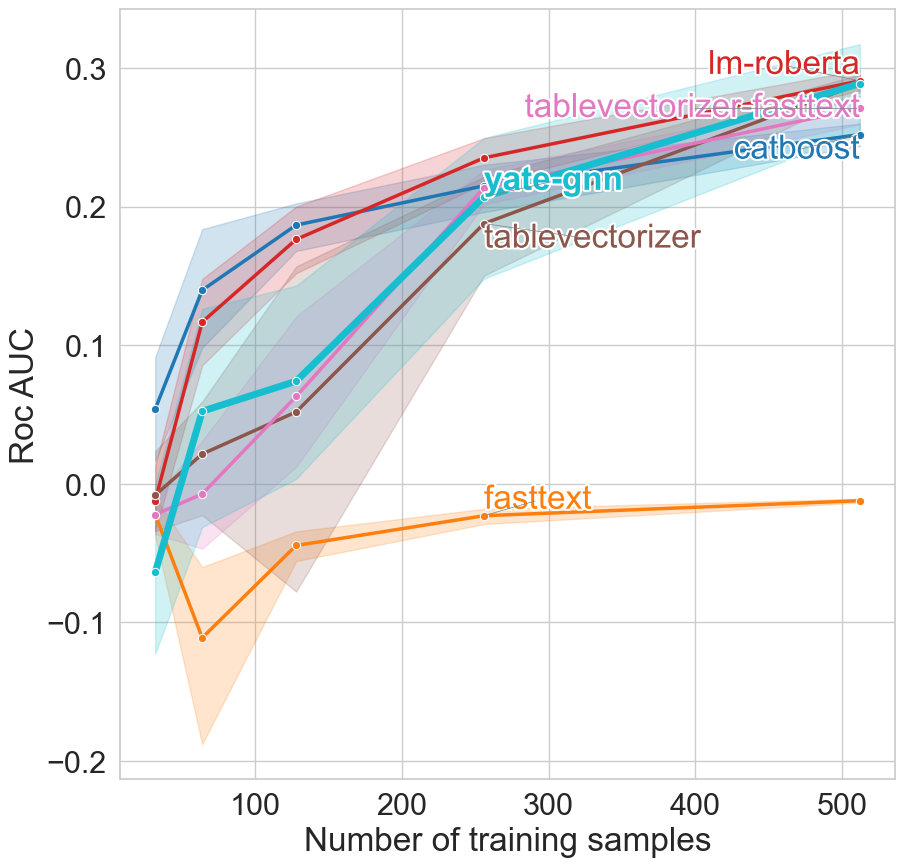

In [108]:
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects


# fig size
plt.figure(figsize=(10, 10))

# paper style
sns.set(style="whitegrid", font_scale=2)

# Create the lineplot
ax = sns.lineplot(
    x="num_train",
    y="r2",
    hue="model",
    data=df_pivot,
    marker="o",
    palette=model_color_palette,  # Use the custom palette
    linewidth=2.5,
)

# Prepare to annotate the lines with adjustText
texts = []
lines = ax.lines
for i, (model, line) in enumerate(zip(df_pivot['model'].unique(), lines)):
    index = -1 - (i % 2)
    x_last = line.get_xdata()[index]
    y_last = line.get_ydata()[index]
    
    # Make the line corresponding to "yate_gnn" model thicker
    if model == "yate-gnn":
        line.set_linewidth(5)  # adjust as needed
        # text bold
        text = ax.text(x_last, y_last, model, color=line.get_color(), weight='bold')
    else:
        text = ax.text(x_last, y_last, model, color=line.get_color())
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    texts.append(text)


# Use adjust_text to repel the labels
adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
# remove legend 
ax.legend_.remove()
ax.set_xlabel("Number of training samples")
if regression:
    ax.set_ylabel("R2 score")
else:
    ax.set_ylabel("Roc AUC")

## Aggregate results

In [103]:
datasets = ["company_employees", "museums", "us_accidents_counts", "us_accidents_severity"]
df_all_origin = pd.DataFrame()
for dataset in datasets:
    new_df, regression = import_data(dataset)
    new_df["dataset"] = dataset
    if regression:
        new_df["score"] = new_df["r2"]
    else:
        new_df["score"] = new_df["roc_auc"]
    df_all_origin = pd.concat([df_all_origin, new_df])

# only keep models that have been trained on all datasets
#TODO: we can relax this constraint if we split e.g classification and regression
models = df_all_origin["model"].unique()
for model in models:
    if len(pd.unique(df_all_origin[df_all_origin["model"] == model]["dataset"])) != len(datasets):
        df_all_origin = df_all_origin[df_all_origin["model"] != model]

### Rank

In [105]:
# compute rank (descending)
df_all = df_all_origin.copy()
df_all["rank"] = df_all.groupby(["num_train", "dataset", "random_state"])["score"].rank(ascending=False)

Text(89.25, 0.5, 'Average rank')

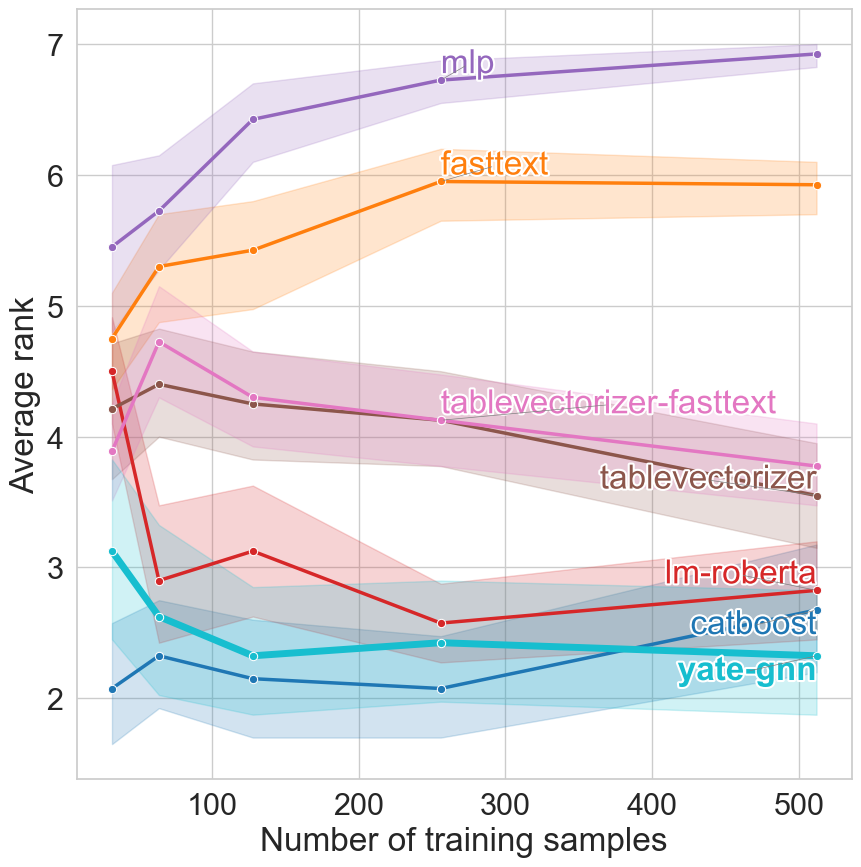

In [109]:
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
# fig size
plt.figure(figsize=(10, 10))


# Create the lineplot
ax = sns.lineplot(
    x="num_train",
    y="rank",
    hue="model",
    data=df_all,
    marker="o",
    linewidth=2.5,
    palette=model_color_palette  # Use the custom palette
)

# Prepare to annotate the lines with adjustText
texts = []
lines = ax.lines
for i, (model, line) in enumerate(zip(df_all['model'].unique(), lines)):
    index = -1 - (i % 2)
    x_last = line.get_xdata()[index]
    y_last = line.get_ydata()[index]
    
    # Make the line corresponding to "yate_gnn" model thicker
    if model == "yate-gnn":
        line.set_linewidth(5)  # adjust as needed
        # text bold
        text = ax.text(x_last, y_last, model, color=line.get_color(), weight='bold')
    else:
        text = ax.text(x_last, y_last, model, color=line.get_color())
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    texts.append(text)


# Use adjust_text to repel the labels
adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
# remove legend 
ax.legend_.remove()
ax.set_xlabel("Number of training samples")
ax.set_ylabel("Average rank")

### Normalized accuracy

Some questions:
- do we want to aggregate classification and regression? If so we should check that it's not to weird, e.g that the spread is not too different between the two settings.
- is the min okay or do we want to take a quantile? Depends if you have really poor models,  but I think it's the case.
- in which group do we want to aggregate. Several possibilities:
    - dataset
    - dataset, random_state: I think I prefer this one
    - dataset, random_state, num_train: this one may be confusing as it won't be monotonous

In [124]:
# Compute normalized scores
def normalize(group, stategy='minmax'):
    # assume the score is to be maximized
    # so r2 or roc_auc but not rmse
    if stategy == 'minmax':
        min_score = group['score'].min()
        max_score = group['score'].max()
        group["min_score"] = min_score
        group["max_score"] = max_score
        group['normalized_score'] = (group['score'] - min_score) / (max_score - min_score)
    elif isinstance(stategy, float):
        # if it is a float, it is the quantile we use instead of the min
        min_score = group['score'].quantile(stategy)
        max_score = group['score'].max()
        group["min_score"] = min_score
        group["max_score"] = max_score
        group['normalized_score'] = (group['score'] - min_score) / (max_score - min_score)
        # if lower than the quantile, set to 0
        group.loc[group['score'] < min_score, 'normalized_score'] = 0
    return group

df_all = df_all_origin.copy()
# there are different possiblity
# I think i prefer this one
df_all = df_all.groupby(['dataset', 'random_state']).apply(normalize, stategy=0.1)
#df_all = df_all.groupby(['num_train', 'dataset', 'random_state']).apply(normalize, stategy=0.1)
#df_all = df_all.groupby(['dataset']).apply(normalize, stategy=0.1)

#### Plot score and normalized score for each dataset to check

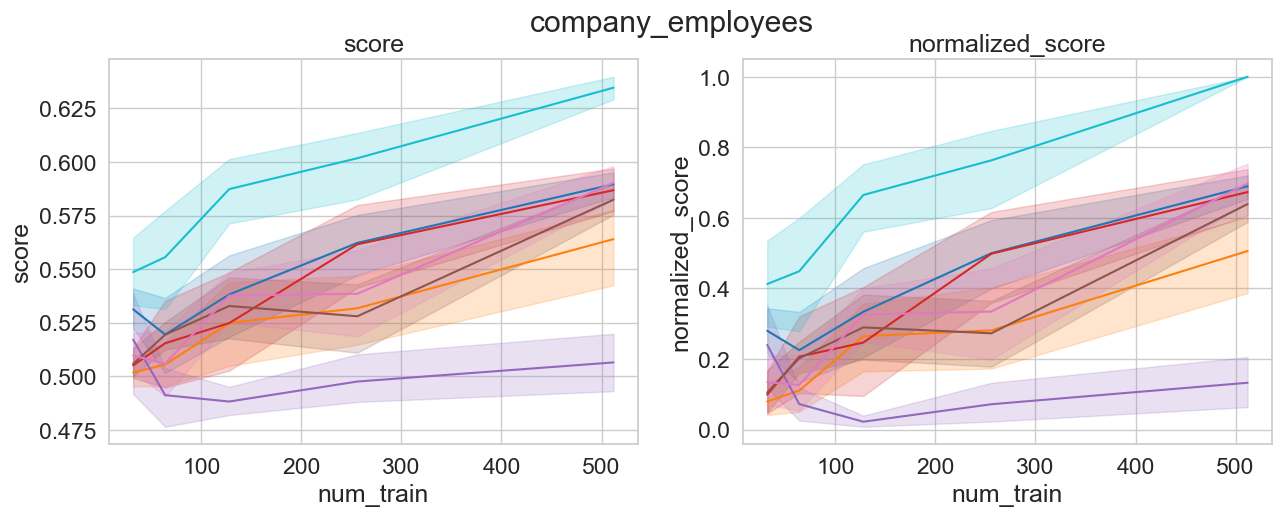

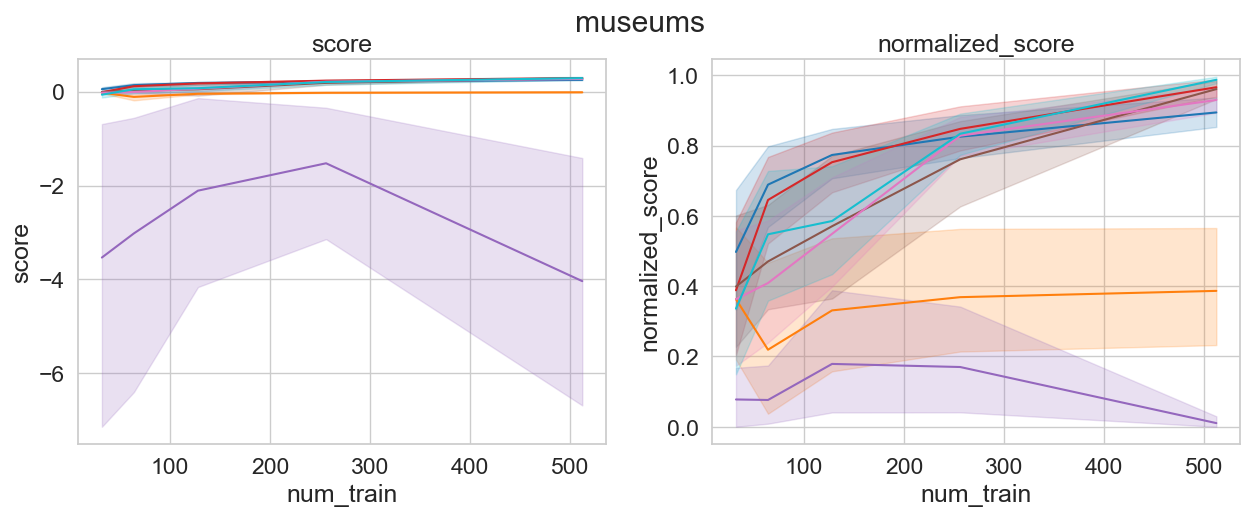

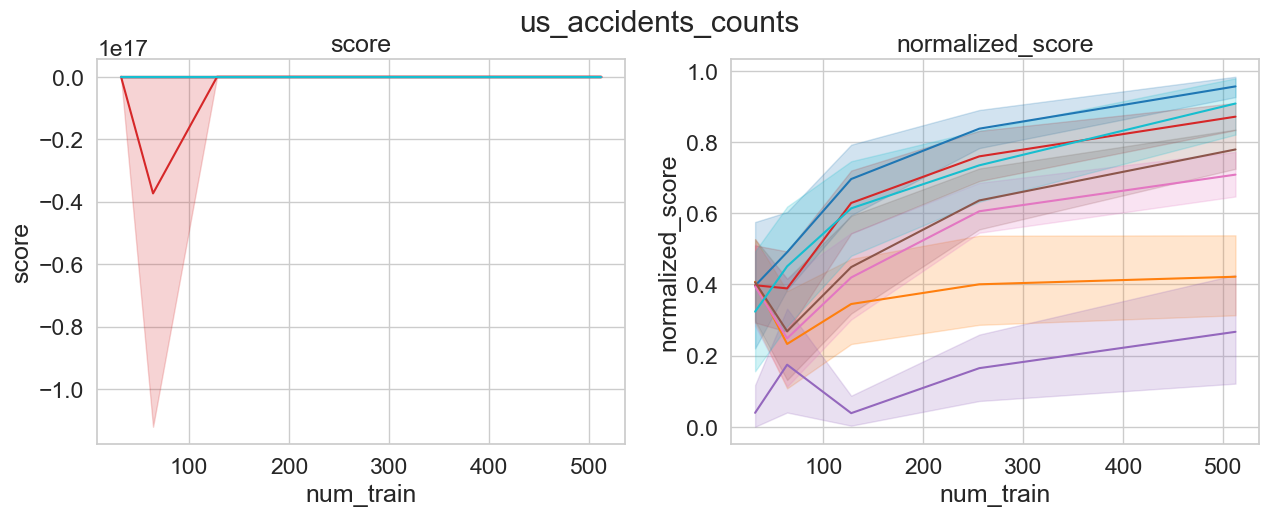

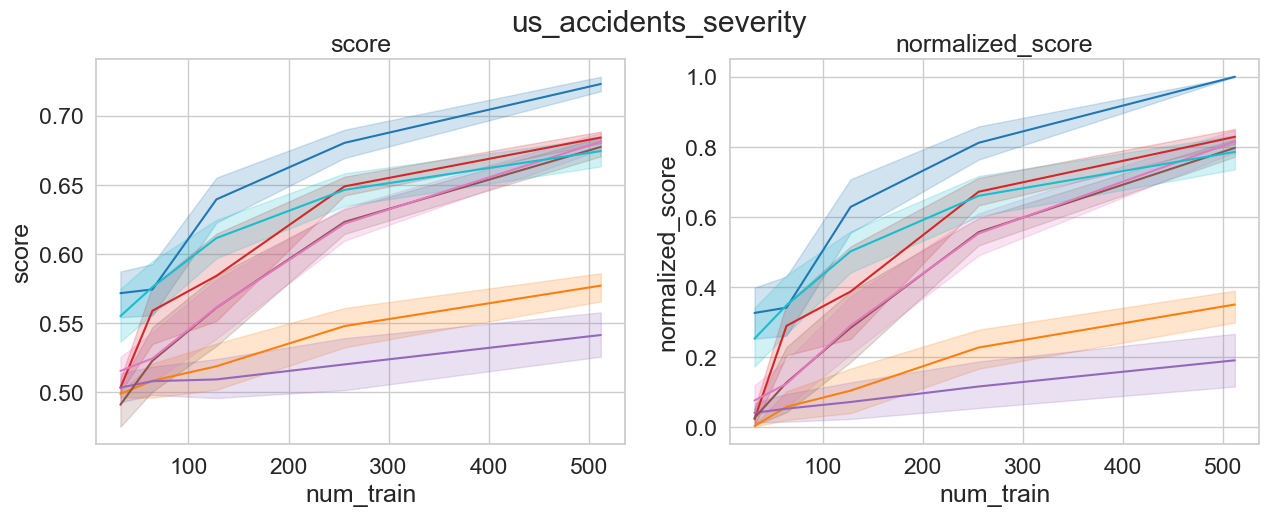

In [125]:
# for each dataset, plot the score and normalized_score for each model

# create a plot for each dataset
for dataset in datasets:
    # 2 subplots, one for score, one for normalized_score
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(dataset)
    # plot the score for each model
    axs[0].set_title('score')
    sns.lineplot(x='num_train', y='score', data=df_all[df_all['dataset'] == dataset], ax=axs[0], hue='model',
        palette=model_color_palette)
    # plot the normalized_score for each model
    axs[1].set_title('normalized_score')
    sns.lineplot(x='num_train', y='normalized_score', data=df_all[df_all['dataset'] == dataset], ax=axs[1], hue='model',
        palette=model_color_palette)
    # remove the legend
    axs[0].legend().remove()
    axs[1].legend().remove()



#### Plot aggregation

Text(74.375, 0.5, 'Normalized score')

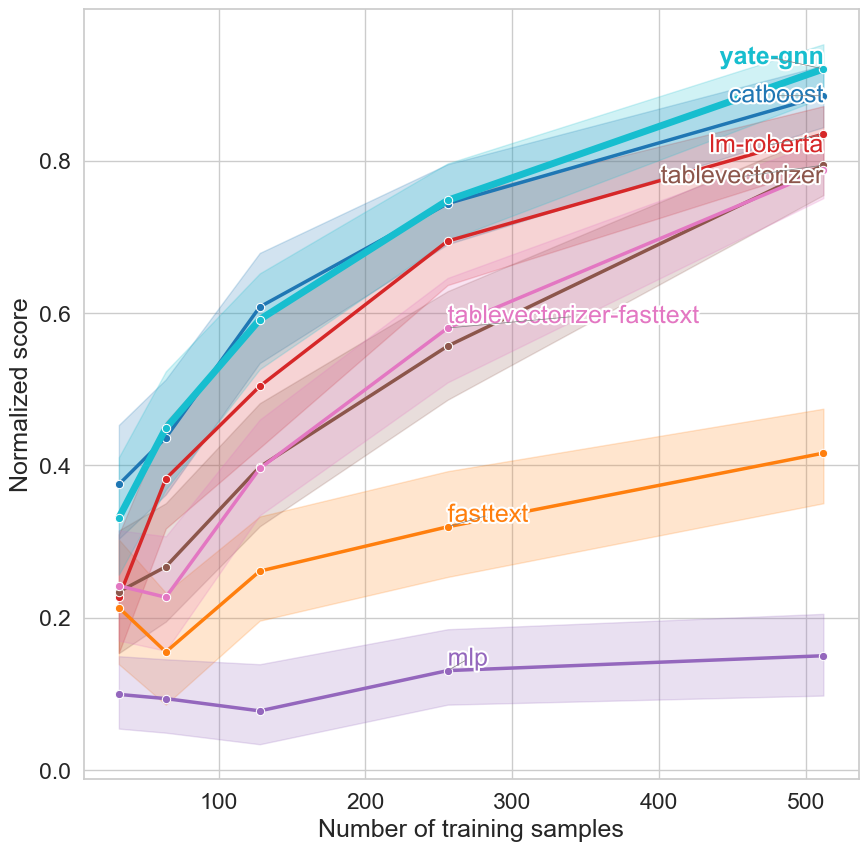

In [121]:
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
# fig size
plt.figure(figsize=(10, 10))

# paper style
sns.set(style="whitegrid", font_scale=1.5)

# Create the lineplot
ax = sns.lineplot(
    x="num_train",
    y="normalized_score",
    hue="model",
    data=df_all,
    marker="o",
    linewidth=2.5,
    palette=model_color_palette  # Use the custom palette
)

# Prepare to annotate the lines with adjustText
texts = []
lines = ax.lines
for i, (model, line) in enumerate(zip(df_all['model'].unique(), lines)):
    index = -1 - (i % 2)
    x_last = line.get_xdata()[index]
    y_last = line.get_ydata()[index]
    
    # Make the line corresponding to "yate_gnn" model thicker
    if model == "yate-gnn":
        line.set_linewidth(5)  # adjust as needed
        # text bold
        text = ax.text(x_last, y_last, model, color=line.get_color(), weight='bold')
    else:
        text = ax.text(x_last, y_last, model, color=line.get_color())
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    texts.append(text)


# Use adjust_text to repel the labels
adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
# remove legend 
ax.legend_.remove()
ax.set_xlabel("Number of training samples")
ax.set_ylabel("Normalized score")

# Critical difference

## For one dataset (doesn't make much sense)

In [ ]:
df, regression = import_data("company_employees")

In [ ]:
df

metric,random_state,num_train,model,avg_precision,roc_auc,run_time
0,1,32,catboost,0.525731,0.516323,289.0203
1,1,32,fasttext,0.489973,0.500000,27.2469
2,1,32,ken,0.483179,0.507726,9.1989
3,1,32,lm-roberta,0.489973,0.500000,3.6111
4,1,32,mlp,0.514848,0.547025,1295.8819
...,...,...,...,...,...,...
495,10,512,tablevectorizer,0.563131,0.584424,190.5754
496,10,512,tablevectorizer-fasttext,0.581626,0.593545,972.3249
497,10,512,tablevectorizer-ken,0.603706,0.634369,736.9804
498,10,512,tabpfn,0.539608,0.557632,1.3198


In [ ]:
df = df[df["num_train"] == 32]
df_for_critdd = df[["random_state", "model", "roc_auc"]].pivot(
    index = "random_state",
    columns = "model",
    values = "roc_auc"
)

In [ ]:
from critdd import Diagram

diagram = Diagram(
    df_for_critdd.to_numpy(),
    treatment_names = df_for_critdd.columns,
    maximize_outcome = True
)

/Users/leo/mambaforge/envs/yate/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
#diagram.average_ranks # the average rank of each treatment
diagram.get_groups(alpha=.05, adjustment="holm")

# plot the diagram
diagram.to_file(
    "example.tex",
    alpha = .05,
    adjustment = "holm",
    reverse_x = True,
    axis_options = {"title": "critdd"},
)

FileNotFoundError: [Errno 2] No such file or directory: 'pdf2svg'

## For all datasets

In [ ]:
datasets = ["company_employees", "museums", "us_accidents_counts", "us_accidents_severity"]
df_all = pd.DataFrame()
for dataset in datasets:
    new_df, regression = import_data(dataset)
    new_df["dataset"] = dataset
    if regression:
        new_df["score"] = new_df["r2"]
    else:
        new_df["score"] = new_df["roc_auc"]
    df_all = pd.concat([df_all, new_df])
    

In [ ]:
num_train = 32
df_all = df_all[df_all["num_train"] == num_train]
# average the scores over the random states
df_all = df_all.groupby(["dataset", "model", "num_train"]).mean().reset_index()
# only keep models that have been trained on all datasets
#TODO: can we relax this constraint?
models = df_all["model"].unique()
for model in models:
    if len(df_all[df_all["model"] == model]) != len(df_all["dataset"].unique()):
        df_all = df_all[df_all["model"] != model]
df_for_critdd = df_all[["dataset", "model", "score"]].pivot(
    index = "dataset",
    columns = "model",
    values = "score"
)

In [ ]:
from critdd import Diagram

diagram = Diagram(
    df_for_critdd.to_numpy(),
    treatment_names = df_for_critdd.columns,
    maximize_outcome = True
)


In [ ]:
diagram.average_ranks # the average rank of each treatment
#diagram.get_groups(alpha=.05, adjustment="holm")



array([2.25, 4.75, 4.5 , 5.25, 4.  , 3.5 , 3.75])

In [ ]:
# plot the diagram
diagram.to_file(
    f"all_datasets_{num_train}.svg",
    alpha = .05,
    adjustment = "holm",
    reverse_x = True,
    axis_options = {"title": "critdd"},
)

FileNotFoundError: [Errno 2] No such file or directory: 'pdf2svg'

# Table plot: comparing pretrained and not pretrained

## Generate toy data

In [11]:
import pandas as pd
import numpy as np

# Define our categories
datasets = ['DatasetA', 'DatasetB', 'DatasetC', 'DatasetD', 'DatasetE', 'DatasetF']
models = ['pretrained', 'not_pretrained']
random_states = list(range(11))  # Values from 0 to 10

# Create an empty list to store our data rows
data_rows = []

np.random.seed(0)  # For reproducibility

# Generate data for each combination
for dataset in datasets:
    for model in models:
        for r_state in random_states:
            score = np.random.rand()
            data_rows.append([model, score, dataset, r_state])

# Convert the list of rows to a DataFrame
df = pd.DataFrame(data_rows, columns=['model', 'score', 'dataset', 'random_state'])

print(df)


              model     score   dataset  random_state
0        pretrained  0.548814  DatasetA             0
1        pretrained  0.715189  DatasetA             1
2        pretrained  0.602763  DatasetA             2
3        pretrained  0.544883  DatasetA             3
4        pretrained  0.423655  DatasetA             4
..              ...       ...       ...           ...
127  not_pretrained  0.301575  DatasetF             6
128  not_pretrained  0.660174  DatasetF             7
129  not_pretrained  0.290078  DatasetF             8
130  not_pretrained  0.618015  DatasetF             9
131  not_pretrained  0.428769  DatasetF            10

[132 rows x 4 columns]


## Plot

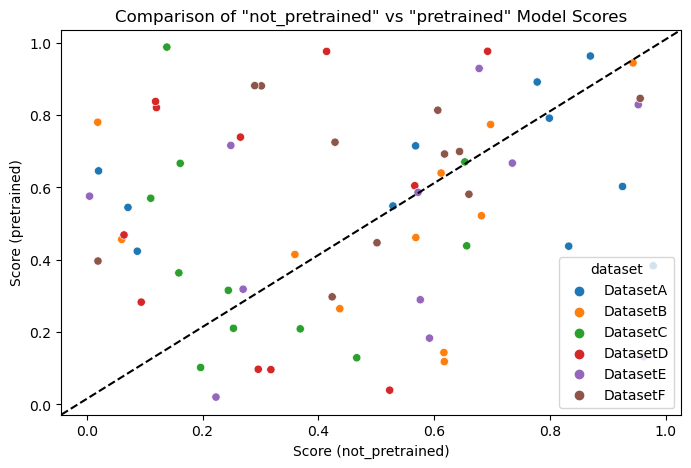

In [18]:
# Reshape the dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pivot_df = df.pivot_table(index=["dataset", "random_state"], columns="model", values="score")

# Scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x='not_pretrained', y='pretrained', data=pivot_df, hue='dataset')
# diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='black')
plt.title('Comparison of "not_pretrained" vs "pretrained" Model Scores')
plt.xlabel('Score (not_pretrained)')
plt.ylabel('Score (pretrained)')
plt.show()

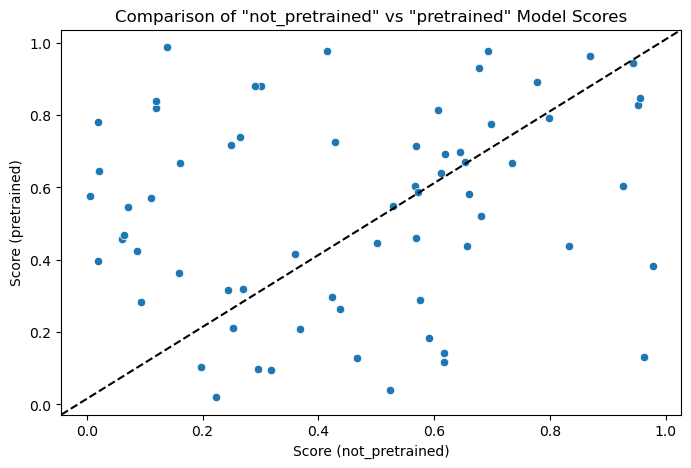

In [19]:
# Reshape the dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pivot_df = df.pivot_table(index=["dataset", "random_state"], columns="model", values="score")

# Scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x='not_pretrained', y='pretrained', data=pivot_df)
# diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='black')
plt.title('Comparison of "not_pretrained" vs "pretrained" Model Scores')
plt.xlabel('Score (not_pretrained)')
plt.ylabel('Score (pretrained)')
plt.show()

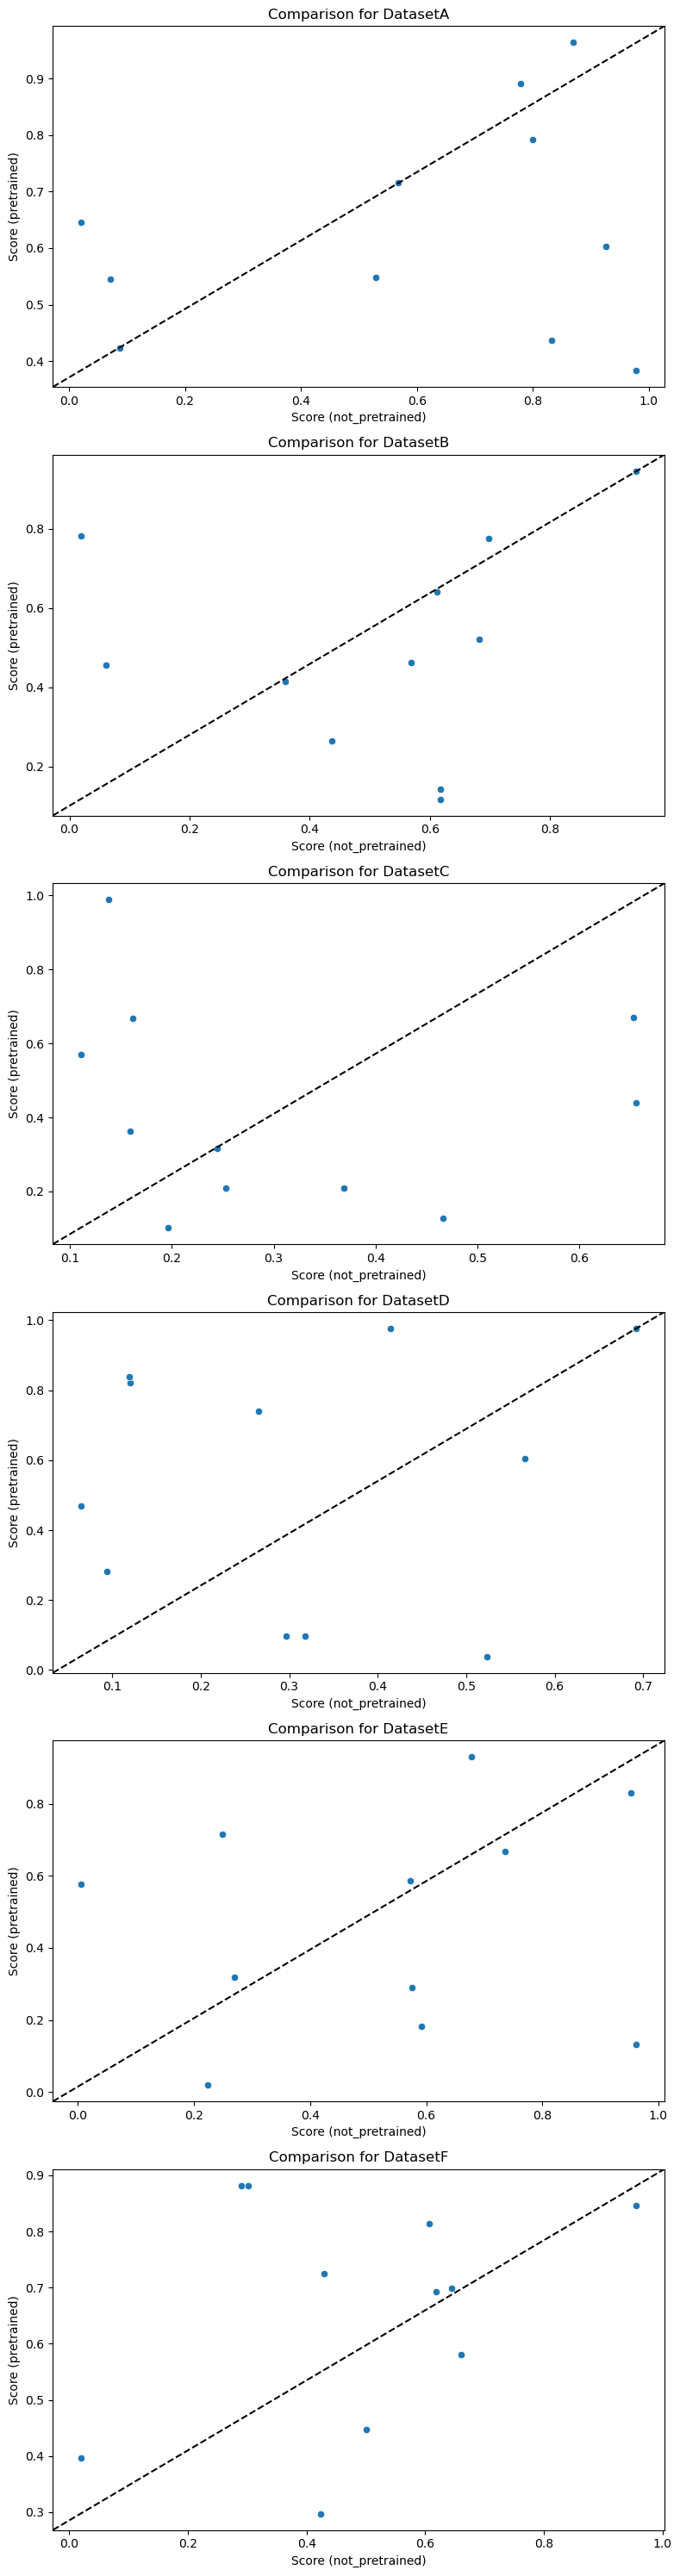

In [20]:
# make subplots for each dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is the one generated from the previous steps

pivot_df = df.pivot_table(index=["dataset", "random_state"], columns="model", values="score")

unique_datasets = df['dataset'].unique()

# Setting up the subplots
fig, axes = plt.subplots(nrows=len(unique_datasets), figsize=(8, 5 * len(unique_datasets)))

for idx, dataset in enumerate(unique_datasets):
    subset = pivot_df.loc[dataset]  # Filter data for the specific dataset
    
    sns.scatterplot(x='not_pretrained', y='pretrained', data=subset, ax=axes[idx])
    # diagonal line
    axes[idx].plot([0, 1], [0, 1], transform=axes[idx].transAxes, ls='--', c='black')
    axes[idx].set_title(f'Comparison for {dataset}')
    axes[idx].set_xlabel('Score (not_pretrained)')
    axes[idx].set_ylabel('Score (pretrained)')

plt.tight_layout()
plt.show()
